<a href="https://colab.research.google.com/github/Calcifer777/learn-nlp/blob/main/custom_nmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install -q transformers torchmetrics

In [1]:
%matplotlib inline

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

## Dataset

In [3]:
%%bash

test -d data || mkdir data 
wget -q https://raw.githubusercontent.com/L1aoXingyu/seq2seq-translation/master/data/eng-fra.txt -O data/eng-fra.txt

In [4]:
import unicodedata
import re

from torch.utils.data import Dataset, DataLoader

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
class EnFrDataset(Dataset):

  def __init__(self, path: str):
    with open(path, "r", encoding="utf-8") as fp:
      self.lines = [
          [normalizeString(s.strip()) for s in l.split("\t")] 
          for l in fp.readlines()
          if len(l.split("\t")) == 2
      ]
    self.lines = [l for l in self.lines if len(l[0]) < 50 and len(l[1]) < 50]
    self.fields = ["src", "tgt"]

  def __len__(self):
    return len(self.lines)

  def __getitem__(self, idx):
    return self.lines[idx]


In [7]:
ds = EnFrDataset(path="data/eng-fra.txt")

In [8]:
ds[50003]

['she had a new dress made .', 'elle s est fait faire une nouvelle robe .']

## Data Loader

In [10]:
from transformers import DistilBertTokenizer 
from functools import partial

In [11]:
BATCH_SIZE = 32

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [13]:
def collate_fn(samples):
  samples = list(map(list, zip(*samples)))
  tokenize = partial(tokenizer.batch_encode_plus, return_tensors="pt", padding=True)
  return dict(
      src_tokens=tokenize(samples[0])["input_ids"],
      tgt_tokens=tokenize(samples[1])["input_ids"]
  )

In [14]:
dl = DataLoader(
    dataset=ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

In [15]:
sample_batch = next(iter(dl))

## Models

In [47]:
import random
import numpy as np

from torch import nn
from torch.nn import functional as F

In [49]:
HIDDEN_SIZE = 256

In [50]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, device="cpu"):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size
    self.device = device

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

  def forward(self, input, hidden=None):
    hidden = (
      self.init_hidden(input.shape[0]).to(device) if hidden is None 
      else hidden
    )
    o, h = self.gru(self.embedding(input), hidden)
    return {"output": o, "hidden": h}

  def init_hidden(self, batch_size):
    return torch.zeros(1, batch_size, self.hidden_size)

In [51]:
# encoder = Encoder(input_size=tokenizer.vocab_size, hidden_size=HIDDEN_SIZE)
# enc_out = encoder(
#     input=sample_batch["src_tokens"], 
#     # hidden=encoder.initHidden(batch_size=BATCH_SIZE)
# )
# print(f"{enc_out['output'].shape = }")
# print(f"{enc_out['hidden'].shape = }")

In [52]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.mha = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=1, batch_first=True)
        self.attn_combine = nn.Linear(hidden_size*2, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, enc_output):
        
        # embeddings: batch, 1, H
        embeddings = self.embedding(input)

        # attn_scores: batch, 1, H
        # attn_weights: batch, 1, T_src
        attn_scores, attn_weights = self.mha(hidden.permute(1, 0, 2), enc_output, enc_output)

        # Combine attn outputs with decoder input via a FF layer
        # rnn_input: batch, 1, H
        rnn_input = self.attn_combine(torch.cat([embeddings, attn_scores], dim=-1))
        rnn_input = F.relu(rnn_input)

        # Feed the rnn input and the previous hidden state to the RNN layer
        # rnn_o: batch, 1, H
        # rnn_h: 1, batch, H
        rnn_o, rnn_h = self.gru(rnn_input, hidden)

        # out: batch, 1, vocab_tgt_size
        out = self.out(rnn_o)
        
        return {
            "output": out,
            "hidden": rnn_h,
            "attention_weights": attn_weights,
        }

In [53]:
# decoder = Decoder(
#     input_size=tokenizer.vocab_size,
#     hidden_size=HIDDEN_SIZE,
#     output_size=tokenizer.vocab_size,
# )
# self = decoder

# decoder_out = decoder(
#     input=sample_batch["tgt_tokens"][:, :1],
#     hidden=torch.rand(1, BATCH_SIZE, HIDDEN_SIZE),
#     enc_output=enc_out['output'],
# )
# print(f"{decoder_out['output'].shape = }")
# print(f"{decoder_out['hidden'].shape = }")
# print(f"{decoder_out['attention_weights'].shape = }")

In [131]:
tokenizer.eos_token_id

In [69]:
class Seq2Seq(nn.Module):
  def __init__(
      self, 
      input_size, 
      hidden_size, 
      output_size, 
      device,
      teacher_forcing_ratio=0.5, 
      max_length=50, 
      cls_token=101,
      eos_token=102,
      sep_token=102,
    ):
    super(Seq2Seq, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.device = device

    self.encoder = Encoder(
      input_size=input_size, 
      hidden_size=hidden_size, 
      device=device
    ).to(device)
    self.decoder = Decoder(
      input_size=input_size, 
      hidden_size=hidden_size, 
      output_size=output_size,
    ).to(device)

    self.teacher_forcing_ratio = teacher_forcing_ratio
    self.max_length = max_length
    self.cls_token = cls_token
    self.eos_token = eos_token
    self.sep_token = sep_token

  def forward(self, input_enc, input_dec):
    enc_out = self.encoder(input_enc)

    use_teacher_forcing = random.random() < self.teacher_forcing_ratio

    outputs = []
    attention_weights = []
    
    batch_size = input_enc.shape[0]
    dec_in = torch.ones((batch_size, 1)).long().to(self.device) * self.cls_token
    dec_h = enc_out["hidden"]
    
    target_length = input_dec.shape[1]
    for idx in range(target_length):

      dec_out = self.decoder(
        input=dec_in,
        hidden=dec_h,
        enc_output=enc_out["output"],
      )
      dec_h = dec_out["hidden"]
      outputs.append(dec_out["output"])
      attention_weights.append(dec_out["attention_weights"])

      if use_teacher_forcing is False:
        # Use decoder prediction as next output
        _, top_idx = dec_out["output"].topk(1)
        dec_in = top_idx.squeeze(1).detach()
      elif use_teacher_forcing is True and (idx + 1 < target_length):
        # Use target values as next output
        # Skip this step if last iteration
        dec_in = input_dec[:, idx+1].unsqueeze(1)

    return {
        # batch, T_tgt, vocab_size_tgt
        "output": torch.cat(outputs, dim=1),
        # batch, T_src, T_tgt
        "attention_weights": torch.cat(attention_weights, dim=1),
    }
  
  def predict(self, input_enc):
    enc_out = self.encoder(input_enc)

    outputs = [self.cls_token]
    attention_weights = []
    
    batch_size = input_enc.shape[0]
    dec_in = torch.ones((batch_size, 1)).long().to(self.device) * self.cls_token
    dec_h = enc_out["hidden"]
    
    for idx in range(self.max_length):

      dec_out = self.decoder(
        input=dec_in,
        hidden=dec_h,
        enc_output=enc_out["output"],
      )
      dec_h = dec_out["hidden"]
      attention_weights.append(dec_out["attention_weights"])

      # Use decoder prediction as next output
      _, top_idx = dec_out["output"].topk(1)
      dec_in = top_idx.squeeze(1).detach()
      predicted_token = dec_in[0].item()
      outputs.append(predicted_token)
      if predicted_token in [self.eos_token, self.sep_token]:
        break
      
    return {
        # batch, T_tgt, vocab_size_tgt
        "output": torch.LongTensor(outputs),
        # batch, T_src, T_tgt
        "attention_weights": torch.cat(attention_weights, dim=1),
    }    


In [55]:
# seq2seq = Seq2Seq(
#      input_size=tokenizer.vocab_size,
#      hidden_size=HIDDEN_SIZE,
#      output_size=tokenizer.vocab_size,
#      device=device,
# )
# self = seq2seq

# input_enc = sample_batch["src_tokens"]
# input_dec = sample_batch["tgt_tokens"]

# seq2seq_out = seq2seq(
#     input_enc=input_enc.to(device),
#     input_dec=input_dec.to(device),
# )
# seq2seq_out["output"].shape

In [56]:
# seq2seq_pred_out = seq2seq.predict(input_enc=input_enc[:1].to(device))

# print(f"{seq2seq_pred_out['output'].shape=}")
# print(f"{seq2seq_pred_out['attention_weights'].shape=}")

# Train

In [119]:
import numpy as np
from tqdm import tqdm

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torchmetrics

In [120]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(0)

In [121]:
model = Seq2Seq(
     input_size=tokenizer.vocab_size,
     hidden_size=HIDDEN_SIZE,
     output_size=tokenizer.vocab_size,
     device=device,
     cls_token=tokenizer.cls_token_id,
     eos_token=tokenizer.eos_token_id,
     sep_token=tokenizer.sep_token_id,
).to(device)
optimizer = Adam(params=model.parameters())
loss_fn = CrossEntropyLoss(ignore_index=0)

In [122]:
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=model.output_size).to(device)

In [123]:
epochs = 5

In [124]:
losses = []
accuracies = []

model.train()


for epoch_id in range(epochs):
  pbar = tqdm(enumerate(dl), total=len(dl))
  accuracy.reset()
  for idx, batch in pbar:
    output = model(
      input_enc=batch["src_tokens"].to(device),
      input_dec=batch["tgt_tokens"][:, :-1].to(device),
    )
    labels = batch["tgt_tokens"][:, 1:].to(device)
    loss = loss_fn(
      output["output"].view(-1, model.output_size), 
      labels.reshape(-1),
    )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    accuracy.update(
      preds=output["output"].view(-1, model.output_size),
      target=labels.reshape(-1),
    )

    losses.append(loss.item())
    accuracies.append(accuracy.compute().item())

    pbar.set_description((
      f"Epoch: {epoch_id:2}\t"
      f"Loss: {np.mean(losses):.3f}\t"
      f"Accuracy: {accuracies[-1]:3%}\t"
    ))

Epoch:  4	Loss: 2.700	Accuracy: 35.228109%	: 100%|██████████| 3481/3481 [05:13<00:00, 11.09it/s]


In [125]:
from matplotlib import pyplot as plt

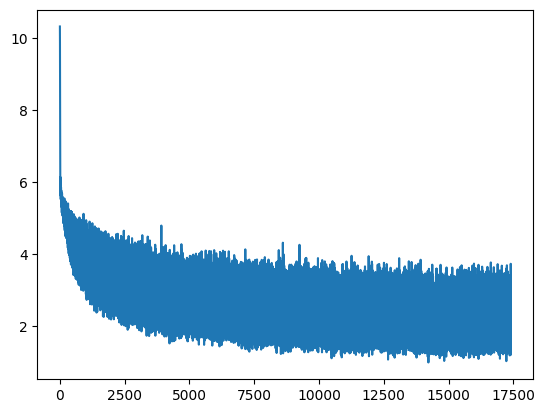

In [126]:
plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

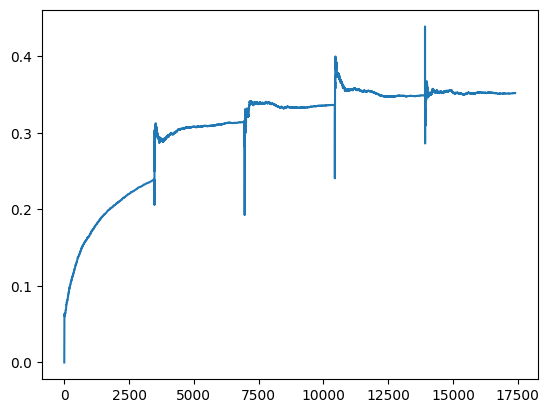

In [127]:
plt.figure()
plt.plot(range(len(accuracies)), accuracies)
plt.show()

# Evaluate

In [156]:
import matplotlib.ticker as ticker

In [183]:
def show_attention(input_tokens, output_tokens, attentions):
  # Set up figure with colorbar
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions, cmap='bone')
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticklabels([""] + input_tokens, rotation=90)
  ax.set_yticklabels(output_tokens)

  # Show label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [214]:
sample_batch = next(iter(dl))
input_ids = sample_batch["src_tokens"][:1]

model.eval()
with torch.no_grad():
  eval_output = model.predict(input_enc=input_ids.to(device))
  output = eval_output["output"]

input_text = tokenizer.decode(input_ids[0])
output_text = tokenizer.decode(output)
target_text = tokenizer.decode(sample_batch['tgt_tokens'][0])

print(f"Source: {input_text}")
print(f"Translation: '{output_text}'")
print(f"Expected: '{target_text}'")

Source: [CLS] do you enjoy talking? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Translation: '[CLS] aimes tu en parler? [SEP]'
Expected: '[CLS] aimes tu discuter? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'


<ipython-input-183-f0c71dd556bd>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + input_tokens, rotation=90)
<ipython-input-183-f0c71dd556bd>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(output_tokens)


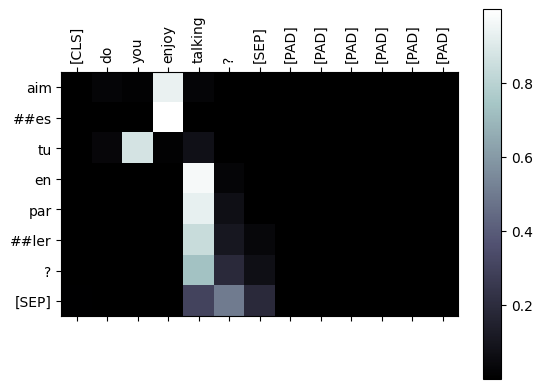

In [215]:
show_attention(
  input_tokens=tokenizer.convert_ids_to_tokens(input_ids[0]),
  output_tokens=tokenizer.convert_ids_to_tokens(output)[:],
  attentions=eval_output["attention_weights"].squeeze(0).cpu().numpy(),
)